In [1]:
#from google.colab import drive 
#drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [1]:
# Import libraries required for the code

from collections import Counter
import re
import time

In [2]:
#import gensim
#import gensim.downloader as api

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

from scipy.sparse import hstack
from scipy.stats import describe

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
#from xgboost import XGBClassifier

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
# Set theme of seaborn 
sns.set()

## Load Training Data, Cross Validation Data and Testing Data

In [6]:
#Train data
train_df = pd.read_csv("new_data_train.csv", sep='\t', index_col=0)
#Validation data
test_df = pd.read_csv("new_data_test.csv", sep='\t', index_col=0)

In [7]:
train_df.head()

,reviewID,reviewerID,restaurantID,date,rating,reviewUsefulCount,reviewContent,flagged,name,location,...,reviewCount,firstCount,usefulCount,coolCount,funnyCount,complimentCount,tipCount,fanCount,restaurantRating,ReviewLength
6010,Z_wgGcI8_Txo87Wz7CxdrQ,cM9GIlk61Qh2thLyJyxNyA,N7juvW8YoFIj7sEBzVF8GQ,9/17/2010,5,0,as new resident chicago los angeles i mission ...,1,suzie n.,"Los Angeles, CA",...,1,0,1,2,0,0,0,0,4.0,144
6566,NJfQb03MSstqYagt860Oaw,SVlSPBnjCzY2Bu9n8y2C5A,o54U2VkQama8FI30qDkWvw,1/31/2008,5,0,great place rarely wait fairly easy find parki...,0,Jacqui B.,"Kalamazoo, MI",...,12,2,19,7,6,4,0,0,4.0,46
21349,2uao3bK9iSV4fuMwuSYCiQ,5HYWhPS3ozYifieW0lWMUw,1QKqtC4vML3QhkrSzwR_tQ,3/31/2010,5,0,back bar makes feel though transported china s...,1,Mike A.,"Los Angeles, CA",...,6,0,7,3,2,0,0,0,3.5,18
10370,6mVU2JfeSbQ-5RnPm-K6eA,dgKmhiTypR34XNPrMtQyMA,4wreIFjaPMppyEnzKHbozg,4/26/2010,5,0,hands one favorite tourist restaurants city th...,0,Jen K.,"Chicago, IL",...,37,2,16,3,3,1,0,1,3.5,41
6011,e25NUAMnVf7-t8-vBO_drA,uB3n74XHDFUKwHxfK5lDvA,N7juvW8YoFIj7sEBzVF8GQ,9/7/2010,5,0,service impeccable staff helpful owner works h...,1,Joe K.,"Barrington, IL",...,3,0,2,1,0,0,0,0,4.0,40


In [8]:
train_df.shape, test_df.shape

((9929, 22), (2483, 22))

In [9]:
train_df.flagged.value_counts()

0    4994
1    4935
Name: flagged, dtype: int64

In [10]:
test_df.flagged.value_counts()

1    1271
0    1212
Name: flagged, dtype: int64

In [11]:
#Check for nan

In [12]:
nan_rows = train_df[train_df['reviewContent'].isnull()]
nan_rows

,reviewID,reviewerID,restaurantID,date,rating,reviewUsefulCount,reviewContent,flagged,name,location,...,reviewCount,firstCount,usefulCount,coolCount,funnyCount,complimentCount,tipCount,fanCount,restaurantRating,ReviewLength
15972,vPx7Ga3vAB7ZLfZsQChlSA,QasfZU1HgCW4LNU8AFFfwg,LMaoM2Ue2BR_HI9ba3JsZg,8/23/2012,4,0,NaN,0,Robert H.,"Denver, CO",...,84,2,16,23,6,9,1,2,4.0,1
25462,ln1j0sucN56GF7NaXqvtkQ,FezvtjI9VD4PZR0vIq-9IQ,43rd1LKcZRIunySzbMsyLQ,9/12/2007,5,0,NaN,1,Txema G.,"Chicago, IL",...,1,0,0,0,1,0,0,0,4.5,1
20728,f83DnEX60KDNk9rqInjWwg,TPOQUpDTdFMPeZwO2nOWQA,O6uWHgJzylSjWjPSJKGhnQ,12/16/2007,3,0,NaN,1,ozlem v.,"Chicago, IL",...,2,0,1,1,0,0,0,0,4.0,1


In [13]:
train_df = train_df[~train_df['reviewContent'].isnull()]
train_df

,reviewID,reviewerID,restaurantID,date,rating,reviewUsefulCount,reviewContent,flagged,name,location,...,reviewCount,firstCount,usefulCount,coolCount,funnyCount,complimentCount,tipCount,fanCount,restaurantRating,ReviewLength
6010,Z_wgGcI8_Txo87Wz7CxdrQ,cM9GIlk61Qh2thLyJyxNyA,N7juvW8YoFIj7sEBzVF8GQ,9/17/2010,5,0,as new resident chicago los angeles i mission ...,1,suzie n.,"Los Angeles, CA",...,1,0,1,2,0,0,0,0,4.0,144
6566,NJfQb03MSstqYagt860Oaw,SVlSPBnjCzY2Bu9n8y2C5A,o54U2VkQama8FI30qDkWvw,1/31/2008,5,0,great place rarely wait fairly easy find parki...,0,Jacqui B.,"Kalamazoo, MI",...,12,2,19,7,6,4,0,0,4.0,46
21349,2uao3bK9iSV4fuMwuSYCiQ,5HYWhPS3ozYifieW0lWMUw,1QKqtC4vML3QhkrSzwR_tQ,3/31/2010,5,0,back bar makes feel though transported china s...,1,Mike A.,"Los Angeles, CA",...,6,0,7,3,2,0,0,0,3.5,18
10370,6mVU2JfeSbQ-5RnPm-K6eA,dgKmhiTypR34XNPrMtQyMA,4wreIFjaPMppyEnzKHbozg,4/26/2010,5,0,hands one favorite tourist restaurants city th...,0,Jen K.,"Chicago, IL",...,37,2,16,3,3,1,0,1,3.5,41
6011,e25NUAMnVf7-t8-vBO_drA,uB3n74XHDFUKwHxfK5lDvA,N7juvW8YoFIj7sEBzVF8GQ,9/7/2010,5,0,service impeccable staff helpful owner works h...,1,Joe K.,"Barrington, IL",...,3,0,2,1,0,0,0,0,4.0,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2072,dK2U-orHZg9ps2g8BRwakA,tPufvUuxXLJOMYQ7gzsMVA,Z2nOMPedr7XYhgYhILJjEA,12/4/2011,4,1,confirming owner s helpful suggestion trick ab...,0,Andrew AndroidTopp T.,"Aurora, IL",...,518,79,538,222,258,111,16,15,4.0,83
20930,ENlbumgWkN3PE97iH7YWuQ,qKF-OwPxog4HdFuPlydllg,tW2jfL-qMccAYZSghPBbHA,1/1/2009,5,0,this best pizza chicago possibly world they am...,1,Rebecca G.,"Chicago, IL",...,3,0,2,0,0,0,0,0,4.0,46
2420,ubhEydMPnwVHLt9IpVi28w,YqVj5efZc2uGwDmgPbPWKA,Z2nOMPedr7XYhgYhILJjEA,1/6/2009,5,0,i love place great beer great service fantasti...,1,Brent C.,"Chicago, IL",...,8,0,0,0,0,0,0,0,4.0,16
3090,0NuFEa_gIMKbj0wsncFlvw,VKIlQivcuKidmmc2EXSlqA,sfWMOqUEp8S2adDeJp7Kzg,7/21/2010,4,0,i always passed place never chance come in fin...,1,Karina Kari A.,"Oak Park, IL",...,2,0,0,0,0,1,1,0,4.0,125


In [14]:
train_df.shape

(9926, 22)

### Dropping Non Textual Features

In [15]:
train_df = train_df[['reviewContent','flagged']]
train_df

,reviewContent,flagged
6010,as new resident chicago los angeles i mission ...,1
6566,great place rarely wait fairly easy find parki...,0
21349,back bar makes feel though transported china s...,1
10370,hands one favorite tourist restaurants city th...,0
6011,service impeccable staff helpful owner works h...,1
...,...,...
2072,confirming owner s helpful suggestion trick ab...,0
20930,this best pizza chicago possibly world they am...,1
2420,i love place great beer great service fantasti...,1
3090,i always passed place never chance come in fin...,1


In [16]:
test_df = test_df[['reviewContent','flagged']]
test_df

,reviewContent,flagged
7267,sunda amazing i heard many good things finally...,1
731,absolutely fantastic foodie community table gr...,0
9902,i work right rarely go here they 5 personal st...,0
25894,this best big 3 brazilian steakhouses chicago ...,1
17519,i lunch the gage group 8 this first time there...,1
...,...,...
13196,there better steak chicago opinion the lobster...,1
10278,it controversial topic i believe giordano s be...,1
11476,this place outrageous i went drinks girls thur...,1
24962,ha i ve eating lunch least twice week two year...,0


## Defining Evaluation Metric

In [17]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_auc_score,roc_curve,auc,confusion_matrix,classification_report

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [18]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [19]:
test_y = test_df.flagged
test_y

7267     1
731      0
9902     0
25894    1
17519    1
        ..
13196    1
10278    1
11476    1
24962    0
17022    0
Name: flagged, Length: 2483, dtype: int64

## 1. Baseline Model: Predicting each value as the majority class ( genuine review )

In [20]:
train_df.flagged.value_counts()

0    4993
1    4933
Name: flagged, dtype: int64

In [21]:
#As we saw before, 0 ('genuine') is the majority class. Lets begin by predicting everything as 0 ('genuine').
preds_test = np.zeros(len(test_df))



In [22]:
#accuracy,f1 on test data 
accuracy = accuracy_score(test_y, preds_test)
precision = precision_score(test_y, preds_test)
recall = recall_score(test_y, preds_test)
f1 = f1_score(test_y, preds_test)

print(f'Accuracy score is: {accuracy}')
print(f'Precision score is: {precision}')
print(f'Recall score is: {recall}')
print(f'F1 score is: {f1}')

Accuracy score is: 0.4881192106322996
Precision score is: 0.0
Recall score is: 0.0
F1 score is: 0.0


In [23]:
print("Confusion Matrix is:")
print(confusion_matrix(test_y, preds_test))

Confusion Matrix is:
[[1212    0]
 [1271    0]]


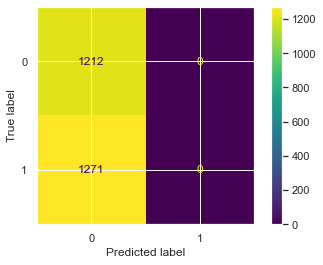

In [24]:


cm = confusion_matrix(test_y, preds_test)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()

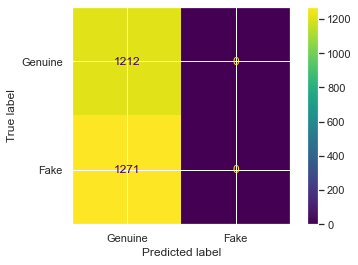

In [25]:
cmd = ConfusionMatrixDisplay(cm, display_labels=['Genuine','Fake'])
cmd.plot()

In [26]:
# Verify the results
sk_tn, sk_fp, sk_fn, sk_tp = confusion_matrix(test_y, preds_test).ravel()
print("Verify our results using Sklearn confusion matrix values\n"
      "FN: {0}\n"
      "TP: {1}\n"
      "TN: {2}\n"
      "FP: {3}".format(sk_fn, sk_tp, sk_tn, sk_fp,))

Verify our results using Sklearn confusion matrix values
FN: 1271
TP: 0
TN: 1212
FP: 0


In [27]:
print("Classification Report is is:")
classification_report_results = classification_report(test_y, preds_test)
# store report in results
print(classification_report_results)

Classification Report is is:
              precision    recall  f1-score   support

           0       0.49      1.00      0.66      1212
           1       0.00      0.00      0.00      1271

    accuracy                           0.49      2483
   macro avg       0.24      0.50      0.33      2483
weighted avg       0.24      0.49      0.32      2483



In [28]:
# Get baseline results
baseline_results = calculate_results(y_true=test_y,
                                     y_pred=preds_test)
baseline_results

{'accuracy': 48.81192106322996, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}

## 3. Featurization of Textual Sentences into Numeric Vectors

**There are three techniques we would use for vectorization:**


**1. Bag Of Words (Unigram, Bigram..)**

**2. TF-IDF**

**3. Word2Vec**

In [29]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chirag/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [30]:
#Load Stopwords from NLTK. We will use these to clean our text
stop_words = set(stopwords.words("english"))

In [31]:
train_df

,reviewContent,flagged
6010,as new resident chicago los angeles i mission ...,1
6566,great place rarely wait fairly easy find parki...,0
21349,back bar makes feel though transported china s...,1
10370,hands one favorite tourist restaurants city th...,0
6011,service impeccable staff helpful owner works h...,1
...,...,...
2072,confirming owner s helpful suggestion trick ab...,0
20930,this best pizza chicago possibly world they am...,1
2420,i love place great beer great service fantasti...,1
3090,i always passed place never chance come in fin...,1


In [32]:
y_train = train_df['flagged']
y_train

6010     1
6566     0
21349    1
10370    0
6011     1
        ..
2072     0
20930    1
2420     1
3090     1
22414    0
Name: flagged, Length: 9926, dtype: int64

In [33]:
test_df

,reviewContent,flagged
7267,sunda amazing i heard many good things finally...,1
731,absolutely fantastic foodie community table gr...,0
9902,i work right rarely go here they 5 personal st...,0
25894,this best big 3 brazilian steakhouses chicago ...,1
17519,i lunch the gage group 8 this first time there...,1
...,...,...
13196,there better steak chicago opinion the lobster...,1
10278,it controversial topic i believe giordano s be...,1
11476,this place outrageous i went drinks girls thur...,1
24962,ha i ve eating lunch least twice week two year...,0


In [34]:
y_test = test_df['flagged']
y_test

7267     1
731      0
9902     0
25894    1
17519    1
        ..
13196    1
10278    1
11476    1
24962    0
17022    0
Name: flagged, Length: 2483, dtype: int64

In [35]:
test_y = y_test
test_y

7267     1
731      0
9902     0
25894    1
17519    1
        ..
13196    1
10278    1
11476    1
24962    0
17022    0
Name: flagged, Length: 2483, dtype: int64

## 3.a) BoW on review Text

In [36]:
unigram = (1, 1)
bigram = (1, 2)
trigram = (1, 3)

#we are trying 2 words at a time
n_gram = bigram

In [37]:
#BoW for vectorization
bow_train = CountVectorizer(
    strip_accents="ascii",
    lowercase=True,
    stop_words=stop_words,
    ngram_range=n_gram,
    min_df=2,
)

#BoW on review text in train data
X_train = bow_train.fit_transform(train_df["reviewContent"])

#get features we derived from training data
train_vocab = bow_train.get_feature_names()

#use those features to vectorize cross val data as well
bow_dev = CountVectorizer(
    strip_accents="ascii",
    lowercase=True,
    stop_words=stop_words,
    ngram_range=n_gram,
    min_df=2,
    vocabulary=train_vocab, #features we got from training
)

#BoW on review text in test data
X_test = bow_dev.fit_transform(test_df["reviewContent"])

In [38]:
X_train.shape

(9926, 80632)

In [39]:
X_test.shape

(2483, 80632)

In [40]:
y_train.shape

(9926,)

In [41]:
y_test.shape

(2483,)

## 4. Model Building

In [42]:
model_results = {}

In [43]:
#Add Baseline
model_results["BASELINE"] = baseline_results

In [44]:
model_results

{'BASELINE': {'accuracy': 48.81192106322996,
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0}}

### a) Logistic Regression

In [51]:
lr = LogisticRegression(max_iter=7600,random_state = 1)
_ = lr.fit(X_train, y_train)

#predictions on test data
preds_test= lr.predict(X_test)

In [53]:
#accuracy,f1 on test data 
accuracy = accuracy_score(test_y, preds_test)
precision = precision_score(test_y, preds_test)
recall = recall_score(test_y, preds_test)
f1 = f1_score(test_y, preds_test)

print(f'Accuracy score is: {accuracy}')
print(f'Precision score is: {precision}')
print(f'Recall score is: {recall}')
print(f'F1 score is: {f1}')

Accuracy score is: 0.662505034232783
Precision score is: 0.6616878267363704
Recall score is: 0.6970889063729347
F1 score is: 0.6789272030651341


In [59]:
print("Confusion Matrix is:")
print(confusion_matrix(test_y, preds_test))

Confusion Matrix is:
[[759 453]
 [385 886]]


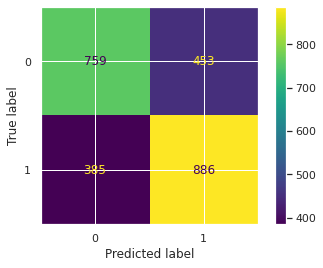

In [61]:
cm = confusion_matrix(test_y, preds_test)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()

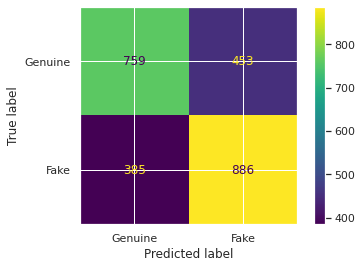

In [62]:
cmd = ConfusionMatrixDisplay(cm, display_labels=['Genuine','Fake'])
cmd.plot()

In [63]:
# Verify the results
sk_tn, sk_fp, sk_fn, sk_tp = confusion_matrix(test_y, preds_test).ravel()
print("Verify our results using Sklearn confusion matrix values\n"
      "FN: {0}\n"
      "TP: {1}\n"
      "TN: {2}\n"
      "FP: {3}".format(sk_fn, sk_tp, sk_tn, sk_fp,))

Verify our results using Sklearn confusion matrix values
FN: 385
TP: 886
TN: 759
FP: 453


In [64]:
print("Classification Report is is:")
classification_report_results = classification_report(test_y, preds_test)
# store report in results
print(classification_report_results)

Classification Report is is:
              precision    recall  f1-score   support

           0       0.66      0.63      0.64      1212
           1       0.66      0.70      0.68      1271

    accuracy                           0.66      2483
   macro avg       0.66      0.66      0.66      2483
weighted avg       0.66      0.66      0.66      2483



In [71]:
print("AUC on Test data is " +str(roc_auc_score(test_y,preds_test)))

AUC on Test data is 0.6616632650676556


In [66]:
# Get baseline results
lr_results = calculate_results(y_true=test_y,
                                     y_pred=preds_test)
lr_results

{'accuracy': 66.25050342327829,
 'precision': 0.6616878267363704,
 'recall': 0.6970889063729347,
 'f1': 0.6789272030651341}

In [69]:
model_results["Logistic Regression"] = lr_results

In [70]:
model_results

{'BASELINE': {'accuracy': 48.81192106322996,
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0},
 'Linear Regression': {'accuracy': 66.25050342327829,
  'precision': 0.6616878267363704,
  'recall': 0.6970889063729347,
  'f1': 0.6789272030651341},
 'Logistic Regression': {'accuracy': 66.25050342327829,
  'precision': 0.6616878267363704,
  'recall': 0.6970889063729347,
  'f1': 0.6789272030651341}}

### b) Decision Tree Classifier

In [74]:
dt = DecisionTreeClassifier(random_state = 1)
_ = dt.fit(X_train, y_train)

#predictions on test data
preds_test= dt.predict(X_test)


In [75]:
#accuracy,f1 on test data 
accuracy = accuracy_score(test_y, preds_test)
precision = precision_score(test_y, preds_test)
recall = recall_score(test_y, preds_test)
f1 = f1_score(test_y, preds_test)

print(f'Accuracy score is: {accuracy}')
print(f'Precision score is: {precision}')
print(f'Recall score is: {recall}')
print(f'F1 score is: {f1}')

Accuracy score is: 0.5884011276681433
Precision score is: 0.5985748218527316
Recall score is: 0.5948072383949646
F1 score is: 0.5966850828729282


In [76]:
print("Confusion Matrix is:")
print(confusion_matrix(test_y, preds_test))

Confusion Matrix is:
[[705 507]
 [515 756]]


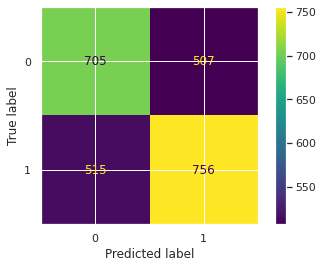

In [77]:
cm = confusion_matrix(test_y, preds_test)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()

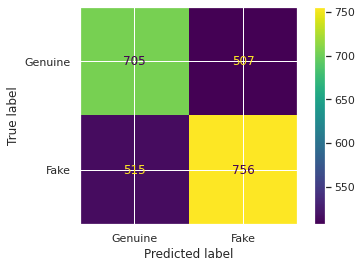

In [78]:
cmd = ConfusionMatrixDisplay(cm, display_labels=['Genuine','Fake'])
cmd.plot()

In [79]:
# Verify the results
sk_tn, sk_fp, sk_fn, sk_tp = confusion_matrix(test_y, preds_test).ravel()
print("Verify our results using Sklearn confusion matrix values\n"
      "FN: {0}\n"
      "TP: {1}\n"
      "TN: {2}\n"
      "FP: {3}".format(sk_fn, sk_tp, sk_tn, sk_fp,))

Verify our results using Sklearn confusion matrix values
FN: 515
TP: 756
TN: 705
FP: 507


In [80]:
print("Classification Report is is:")
classification_report_results = classification_report(test_y, preds_test)
# store report in results
print(classification_report_results)

Classification Report is is:
              precision    recall  f1-score   support

           0       0.58      0.58      0.58      1212
           1       0.60      0.59      0.60      1271

    accuracy                           0.59      2483
   macro avg       0.59      0.59      0.59      2483
weighted avg       0.59      0.59      0.59      2483



In [81]:
print("AUC on Test data is " +str(roc_auc_score(test_y,preds_test)))

AUC on Test data is 0.5882452033558982


In [83]:
# Get baseline results
dt_results = calculate_results(y_true=test_y,
                                     y_pred=preds_test)
dt_results

{'accuracy': 58.840112766814336,
 'precision': 0.5985748218527316,
 'recall': 0.5948072383949646,
 'f1': 0.5966850828729282}

In [84]:
model_results["Decision Tree"] = dt_results

In [85]:
model_results

{'BASELINE': {'accuracy': 48.81192106322996,
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0},
 'Linear Regression': {'accuracy': 66.25050342327829,
  'precision': 0.6616878267363704,
  'recall': 0.6970889063729347,
  'f1': 0.6789272030651341},
 'Logistic Regression': {'accuracy': 66.25050342327829,
  'precision': 0.6616878267363704,
  'recall': 0.6970889063729347,
  'f1': 0.6789272030651341},
 'Decision Tree': {'accuracy': 58.840112766814336,
  'precision': 0.5985748218527316,
  'recall': 0.5948072383949646,
  'f1': 0.5966850828729282}}

We will now try to do some hyperparameter tuning on Decision Tree

In [86]:
from sklearn.model_selection import RandomizedSearchCV

hyperparam_combs = {
    'max_depth': [4, 6, 8, 10, 12],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 10, 20, 30, 40],
    'max_features': [0.2, 0.4, 0.6, 0.8, 1],
    'max_leaf_nodes': [8, 16, 32, 64, 128],
    'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2}, {0: 1, 1: 3}, {0: 1, 1: 4}, {0: 1, 1: 5}]
}

dt2 = RandomizedSearchCV(DecisionTreeClassifier(),
                         hyperparam_combs,
                         scoring='f1',
                         random_state=1,
                         n_iter=30,n_jobs=-1)

search = dt2.fit(X_train, y_train)

search.best_params_

{'min_samples_split': 40,
 'max_leaf_nodes': 128,
 'max_features': 0.4,
 'max_depth': 12,
 'criterion': 'gini',
 'class_weight': {0: 1, 1: 3}}

In [87]:
optimal_params = search.best_params_
optimal_params

{'min_samples_split': 40,
 'max_leaf_nodes': 128,
 'max_features': 0.4,
 'max_depth': 12,
 'criterion': 'gini',
 'class_weight': {0: 1, 1: 3}}

In [88]:
dt2 = DecisionTreeClassifier(random_state = 1, **optimal_params)
_ = dt2.fit(X_train, y_train)


#predictions on test data
preds_test= dt2.predict(X_test)

In [90]:
#accuracy,f1 on test data 
accuracy = accuracy_score(test_y, preds_test)
precision = precision_score(test_y, preds_test)
recall = recall_score(test_y, preds_test)
f1 = f1_score(test_y, preds_test)

print(f'Accuracy score is: {accuracy}')
print(f'Precision score is: {precision}')
print(f'Recall score is: {recall}')
print(f'F1 score is: {f1}')

Accuracy score is: 0.5718888441401531
Precision score is: 0.5468890892696122
Recall score is: 0.9543666404405979
F1 score is: 0.6953281742619661


In [ ]:
#We increased Recall at the cost of Precision ( FN decreased but FP increased)

In [91]:
print("Confusion Matrix is:")
print(confusion_matrix(test_y, preds_test))

Confusion Matrix is:
[[ 207 1005]
 [  58 1213]]


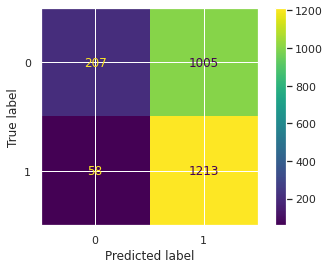

In [92]:
cm = confusion_matrix(test_y, preds_test)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()

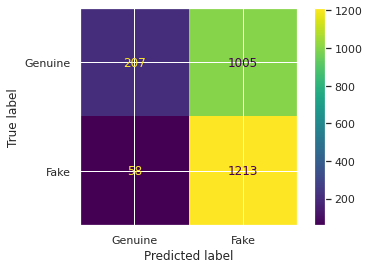

In [93]:
cmd = ConfusionMatrixDisplay(cm, display_labels=['Genuine','Fake'])
cmd.plot()

In [94]:
# Verify the results
sk_tn, sk_fp, sk_fn, sk_tp = confusion_matrix(test_y, preds_test).ravel()
print("Verify our results using Sklearn confusion matrix values\n"
      "FN: {0}\n"
      "TP: {1}\n"
      "TN: {2}\n"
      "FP: {3}".format(sk_fn, sk_tp, sk_tn, sk_fp,))

Verify our results using Sklearn confusion matrix values
FN: 58
TP: 1213
TN: 207
FP: 1005


In [95]:
print("Classification Report is is:")
classification_report_results = classification_report(test_y, preds_test)
# store report in results
print(classification_report_results)

Classification Report is is:
              precision    recall  f1-score   support

           0       0.78      0.17      0.28      1212
           1       0.55      0.95      0.70      1271

    accuracy                           0.57      2483
   macro avg       0.66      0.56      0.49      2483
weighted avg       0.66      0.57      0.49      2483



In [96]:
print("AUC on Test data is " +str(roc_auc_score(test_y,preds_test)))

AUC on Test data is 0.5625793598242593


In [97]:
# Get baseline results
dt_results = calculate_results(y_true=test_y,
                                     y_pred=preds_test)
dt_results

{'accuracy': 57.188884414015305,
 'precision': 0.5468890892696122,
 'recall': 0.9543666404405979,
 'f1': 0.6953281742619661}

In [98]:
model_results["Decision Tree Tuned"] = dt_results

In [99]:
model_results

{'BASELINE': {'accuracy': 48.81192106322996,
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0},
 'Linear Regression': {'accuracy': 66.25050342327829,
  'precision': 0.6616878267363704,
  'recall': 0.6970889063729347,
  'f1': 0.6789272030651341},
 'Logistic Regression': {'accuracy': 66.25050342327829,
  'precision': 0.6616878267363704,
  'recall': 0.6970889063729347,
  'f1': 0.6789272030651341},
 'Decision Tree': {'accuracy': 58.840112766814336,
  'precision': 0.5985748218527316,
  'recall': 0.5948072383949646,
  'f1': 0.5966850828729282},
 'Decision Tree Tuned': {'accuracy': 57.188884414015305,
  'precision': 0.5468890892696122,
  'recall': 0.9543666404405979,
  'f1': 0.6953281742619661}}

c) Random Forest Classifier

In [120]:
#creation of random forrest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=1) #by default no of estimators=10
rf.fit(X_train, y_train)

#predictions on test data
preds_test= rf.predict(X_test)

In [121]:
#f1 score on test set
f1_score(y_test, preds_test)

0.6577181208053692

In [122]:
#accuracy,f1 on test data 
accuracy = accuracy_score(test_y, preds_test)
precision = precision_score(test_y, preds_test)
recall = recall_score(test_y, preds_test)
f1 = f1_score(test_y, preds_test)

print(f'Accuracy score is: {accuracy}')
print(f'Precision score is: {precision}')
print(f'Recall score is: {recall}')
print(f'F1 score is: {f1}')

Accuracy score is: 0.6508256141763995
Precision score is: 0.6600633914421553
Recall score is: 0.6553894571203777
F1 score is: 0.6577181208053692


In [123]:
print("Confusion Matrix is:")
print(confusion_matrix(test_y, preds_test))

Confusion Matrix is:
[[783 429]
 [438 833]]


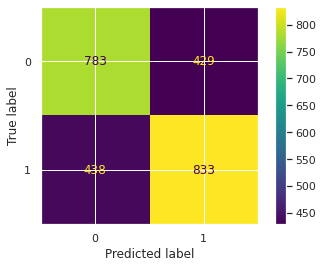

In [124]:
cm = confusion_matrix(test_y, preds_test)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()

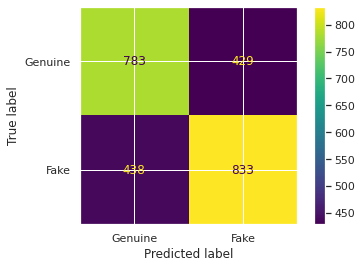

In [125]:
cmd = ConfusionMatrixDisplay(cm, display_labels=['Genuine','Fake'])
cmd.plot()

In [126]:
# Verify the results
sk_tn, sk_fp, sk_fn, sk_tp = confusion_matrix(test_y, preds_test).ravel()
print("Verify our results using Sklearn confusion matrix values\n"
      "FN: {0}\n"
      "TP: {1}\n"
      "TN: {2}\n"
      "FP: {3}".format(sk_fn, sk_tp, sk_tn, sk_fp,))

Verify our results using Sklearn confusion matrix values
FN: 438
TP: 833
TN: 783
FP: 429


In [127]:
print("Classification Report is is:")
classification_report_results = classification_report(test_y, preds_test)
# store report in results
print(classification_report_results)

Classification Report is is:
              precision    recall  f1-score   support

           0       0.64      0.65      0.64      1212
           1       0.66      0.66      0.66      1271

    accuracy                           0.65      2483
   macro avg       0.65      0.65      0.65      2483
weighted avg       0.65      0.65      0.65      2483



In [128]:
print("AUC on Test data is " +str(roc_auc_score(test_y,preds_test)))

AUC on Test data is 0.6507145305403869


In [129]:
# Get baseline results
rf_results = calculate_results(y_true=test_y,
                                     y_pred=preds_test)
rf_results

{'accuracy': 65.08256141763995,
 'precision': 0.6600633914421553,
 'recall': 0.6553894571203777,
 'f1': 0.6577181208053692}

In [130]:
model_results["Random Forest"] = rf_results

In [131]:
model_results

{'BASELINE': {'accuracy': 48.81192106322996,
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0},
 'Linear Regression': {'accuracy': 66.25050342327829,
  'precision': 0.6616878267363704,
  'recall': 0.6970889063729347,
  'f1': 0.6789272030651341},
 'Logistic Regression': {'accuracy': 66.25050342327829,
  'precision': 0.6616878267363704,
  'recall': 0.6970889063729347,
  'f1': 0.6789272030651341},
 'Decision Tree': {'accuracy': 58.840112766814336,
  'precision': 0.5985748218527316,
  'recall': 0.5948072383949646,
  'f1': 0.5966850828729282},
 'Decision Tree Tuned': {'accuracy': 58.477648006443815,
  'precision': 0.553763440860215,
  'recall': 0.9724626278520849,
  'f1': 0.7056808449900085},
 'Random Forest Tuned': {'accuracy': 58.477648006443815,
  'precision': 0.553763440860215,
  'recall': 0.9724626278520849,
  'f1': 0.7056808449900085},
 'Random Forest': {'accuracy': 65.08256141763995,
  'precision': 0.6600633914421553,
  'recall': 0.6553894571203777,
  'f1': 0.6577181208053692}}

In [132]:
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
print(rf.get_params())

Parameters currently in use:

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 1, 'verbose': 0, 'warm_start': False}


In [103]:
from sklearn.model_selection import RandomizedSearchCV

hyperparam_combs = {
    'max_depth': [4, 6, 8, 10, 12],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 10, 20, 30, 40],
    'max_features': [0.2, 0.4, 0.6, 0.8, 1],
    'max_leaf_nodes': [8, 16, 32, 64, 128],
    'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2}, {0: 1, 1: 3}, {0: 1, 1: 4}, {0: 1, 1: 5}]
}

rf2 = RandomizedSearchCV(RandomForestClassifier(),
                         hyperparam_combs,
                         scoring='f1',
                         random_state=1,
                         n_iter=30,n_jobs=-1)

search = rf2.fit(X_train, y_train)

search.best_params_

{'min_samples_split': 40,
 'max_leaf_nodes': 128,
 'max_features': 0.4,
 'max_depth': 12,
 'criterion': 'gini',
 'class_weight': {0: 1, 1: 3}}

In [104]:
optimal_params = search.best_params_
optimal_params

{'min_samples_split': 40,
 'max_leaf_nodes': 128,
 'max_features': 0.4,
 'max_depth': 12,
 'criterion': 'gini',
 'class_weight': {0: 1, 1: 3}}

In [107]:
rf2 = RandomForestClassifier(random_state = 1, **optimal_params)
_ = rf2.fit(X_train, y_train)

#predictions on test data
preds_test= rf2.predict(X_test)



In [108]:
#f1 score on test set
f1_score(y_test, preds_test)

0.7056808449900085

In [109]:
#accuracy,f1 on test data 
accuracy = accuracy_score(test_y, preds_test)
precision = precision_score(test_y, preds_test)
recall = recall_score(test_y, preds_test)
f1 = f1_score(test_y, preds_test)

print(f'Accuracy score is: {accuracy}')
print(f'Precision score is: {precision}')
print(f'Recall score is: {recall}')
print(f'F1 score is: {f1}')

Accuracy score is: 0.5847764800644382
Precision score is: 0.553763440860215
Recall score is: 0.9724626278520849
F1 score is: 0.7056808449900085


In [110]:
print("Confusion Matrix is:")
print(confusion_matrix(test_y, preds_test))

Confusion Matrix is:
[[ 216  996]
 [  35 1236]]


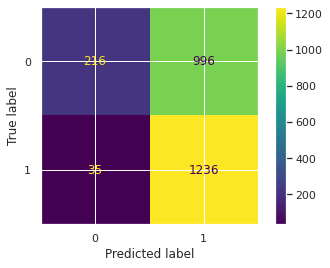

In [111]:
cm = confusion_matrix(test_y, preds_test)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()

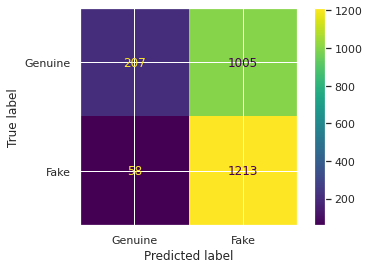

In [ ]:
cmd = ConfusionMatrixDisplay(cm, display_labels=['Genuine','Fake'])
cmd.plot()

In [112]:
# Verify the results
sk_tn, sk_fp, sk_fn, sk_tp = confusion_matrix(test_y, preds_test).ravel()
print("Verify our results using Sklearn confusion matrix values\n"
      "FN: {0}\n"
      "TP: {1}\n"
      "TN: {2}\n"
      "FP: {3}".format(sk_fn, sk_tp, sk_tn, sk_fp,))

Verify our results using Sklearn confusion matrix values
FN: 35
TP: 1236
TN: 216
FP: 996


In [113]:
print("Classification Report is is:")
classification_report_results = classification_report(test_y, preds_test)
# store report in results
print(classification_report_results)

Classification Report is is:
              precision    recall  f1-score   support

           0       0.86      0.18      0.30      1212
           1       0.55      0.97      0.71      1271

    accuracy                           0.58      2483
   macro avg       0.71      0.58      0.50      2483
weighted avg       0.70      0.58      0.51      2483



In [114]:
print("AUC on Test data is " +str(roc_auc_score(test_y,preds_test)))

AUC on Test data is 0.5753402248171315


In [117]:
# Get baseline results
rf_results = calculate_results(y_true=test_y,
                                     y_pred=preds_test)
rf_results

{'accuracy': 58.477648006443815,
 'precision': 0.553763440860215,
 'recall': 0.9724626278520849,
 'f1': 0.7056808449900085}

In [118]:
model_results["Random Forest Tuned"] = rf_results

In [119]:
model_results

{'BASELINE': {'accuracy': 48.81192106322996,
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0},
 'Linear Regression': {'accuracy': 66.25050342327829,
  'precision': 0.6616878267363704,
  'recall': 0.6970889063729347,
  'f1': 0.6789272030651341},
 'Logistic Regression': {'accuracy': 66.25050342327829,
  'precision': 0.6616878267363704,
  'recall': 0.6970889063729347,
  'f1': 0.6789272030651341},
 'Decision Tree': {'accuracy': 58.840112766814336,
  'precision': 0.5985748218527316,
  'recall': 0.5948072383949646,
  'f1': 0.5966850828729282},
 'Decision Tree Tuned': {'accuracy': 58.477648006443815,
  'precision': 0.553763440860215,
  'recall': 0.9724626278520849,
  'f1': 0.7056808449900085},
 'Random Forest Tuned': {'accuracy': 58.477648006443815,
  'precision': 0.553763440860215,
  'recall': 0.9724626278520849,
  'f1': 0.7056808449900085}}

In [139]:
'''
#Visualizing Feature Importance
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(12,12))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), trn[features].columns.values) #trn.columns has list of all columns in our training data
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

plot_feature_importances(rf2)    
'''

'\n#Visualizing Feature Importance\ndef plot_feature_importances(model):\n    n_features = X_train.shape[1]\n    plt.figure(figsize=(12,12))\n    plt.barh(range(n_features), model.feature_importances_, align=\'center\') \n    plt.yticks(np.arange(n_features), trn[features].columns.values) #trn.columns has list of all columns in our training data\n    plt.xlabel("Feature importance")\n    plt.ylabel("Feature")\n\nplot_feature_importances(rf2)    \n'

### d) Support Vector Machines

In [46]:
from sklearn.svm import SVC

svc = SVC(random_state = 1)
_ = svc.fit(X_train, y_train)

#predictions on test data
preds_test= svc.predict(X_test)

In [47]:
#f1 score on test set
f1_score(y_test, preds_test)

0.6804979253112035

In [48]:
#accuracy,f1 on test data 
accuracy = accuracy_score(test_y, preds_test)
precision = precision_score(test_y, preds_test)
recall = recall_score(test_y, preds_test)
f1 = f1_score(test_y, preds_test)

print(f'Accuracy score is: {accuracy}')
print(f'Precision score is: {precision}')
print(f'Recall score is: {recall}')
print(f'F1 score is: {f1}')

Accuracy score is: 0.6588803866290778
Precision score is: 0.6536231884057971
Recall score is: 0.7096774193548387
F1 score is: 0.6804979253112035


In [49]:
print("Confusion Matrix is:")
print(confusion_matrix(test_y, preds_test))

Confusion Matrix is:
[[734 478]
 [369 902]]


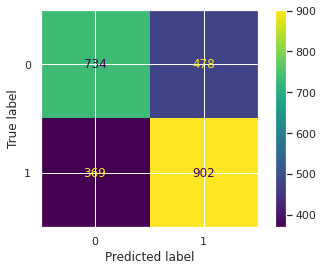

In [50]:
cm = confusion_matrix(test_y, preds_test)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()

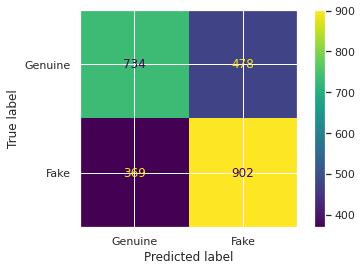

In [51]:
cmd = ConfusionMatrixDisplay(cm, display_labels=['Genuine','Fake'])
cmd.plot()

In [52]:
# Verify the results
sk_tn, sk_fp, sk_fn, sk_tp = confusion_matrix(test_y, preds_test).ravel()
print("Verify our results using Sklearn confusion matrix values\n"
      "FN: {0}\n"
      "TP: {1}\n"
      "TN: {2}\n"
      "FP: {3}".format(sk_fn, sk_tp, sk_tn, sk_fp,))

Verify our results using Sklearn confusion matrix values
FN: 369
TP: 902
TN: 734
FP: 478


In [53]:
print("Classification Report is is:")
classification_report_results = classification_report(test_y, preds_test)
# store report in results
print(classification_report_results)

Classification Report is is:
              precision    recall  f1-score   support

           0       0.67      0.61      0.63      1212
           1       0.65      0.71      0.68      1271

    accuracy                           0.66      2483
   macro avg       0.66      0.66      0.66      2483
weighted avg       0.66      0.66      0.66      2483



In [54]:
print("AUC on Test data is " +str(roc_auc_score(test_y,preds_test)))

AUC on Test data is 0.6576439902054722


In [55]:
svc_results = calculate_results(y_true=test_y,
                                     y_pred=preds_test)
svc_results

{'accuracy': 65.88803866290777,
 'precision': 0.6536231884057971,
 'recall': 0.7096774193548387,
 'f1': 0.6804979253112035}

In [56]:
model_results["SVC"] = svc_results

In [152]:
model_results

{'BASELINE': {'accuracy': 48.81192106322996,
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0},
 'Linear Regression': {'accuracy': 66.25050342327829,
  'precision': 0.6616878267363704,
  'recall': 0.6970889063729347,
  'f1': 0.6789272030651341},
 'Logistic Regression': {'accuracy': 66.25050342327829,
  'precision': 0.6616878267363704,
  'recall': 0.6970889063729347,
  'f1': 0.6789272030651341},
 'Decision Tree': {'accuracy': 58.840112766814336,
  'precision': 0.5985748218527316,
  'recall': 0.5948072383949646,
  'f1': 0.5966850828729282},
 'Decision Tree Tuned': {'accuracy': 58.477648006443815,
  'precision': 0.553763440860215,
  'recall': 0.9724626278520849,
  'f1': 0.7056808449900085},
 'Random Forest Tuned': {'accuracy': 58.477648006443815,
  'precision': 0.553763440860215,
  'recall': 0.9724626278520849,
  'f1': 0.7056808449900085},
 'Random Forest': {'accuracy': 65.08256141763995,
  'precision': 0.6600633914421553,
  'recall': 0.6553894571203777,
  'f1': 0.6577181208053692},
 'SVC

In [57]:
#current parameters
svc.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [58]:
#Now we will do tuning of the hyper-parameters

In [59]:
# List of C values
C_range = np.logspace(-10, 10, 21)
print(f'The list of values for C are {C_range}')

# List of gamma values
gamma_range = np.logspace(-10, 10, 21)
print(f'The list of values for gamma are {gamma_range}')

The list of values for C are [1.e-10 1.e-09 1.e-08 1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01
 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04 1.e+05 1.e+06 1.e+07 1.e+08 1.e+09
 1.e+10]
The list of values for gamma are [1.e-10 1.e-09 1.e-08 1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01
 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04 1.e+05 1.e+06 1.e+07 1.e+08 1.e+09
 1.e+10]


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Define the search space

hyperparam_combs = {
    
    # Regularization parameter.
    "C": C_range,
    # Kernel type
    "kernel": ['rbf', 'poly'],
    # Gamma is the Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.
    "gamma": gamma_range.tolist()+['scale', 'auto']
}


svc2 = RandomizedSearchCV(SVC(),
                         hyperparam_combs,
                         scoring='f1',
                         random_state=1,
                         n_iter=10)

search = svc2.fit(X_train, y_train)

search.best_params_

In [ ]:
optimal_params = search.best_params_
optimal_params

In [ ]:
svc2 = SVC(random_state = 1, **optimal_params)
_ = svc2.fit(X_train, y_train)

#predictions on test data
preds_test= svc2.predict(X_test)



In [ ]:
#f1 score on test set
f1_score(y_test, preds_test)

0.7056808449900085

In [ ]:
#accuracy,f1 on test data 
accuracy = accuracy_score(test_y, preds_test)
precision = precision_score(test_y, preds_test)
recall = recall_score(test_y, preds_test)
f1 = f1_score(test_y, preds_test)

print(f'Accuracy score is: {accuracy}')
print(f'Precision score is: {precision}')
print(f'Recall score is: {recall}')
print(f'F1 score is: {f1}')

Accuracy score is: 0.5847764800644382
Precision score is: 0.553763440860215
Recall score is: 0.9724626278520849
F1 score is: 0.7056808449900085


In [ ]:
print("Confusion Matrix is:")
print(confusion_matrix(test_y, preds_test))

Confusion Matrix is:
[[ 216  996]
 [  35 1236]]


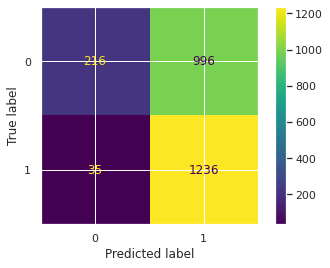

In [ ]:
cm = confusion_matrix(test_y, preds_test)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()

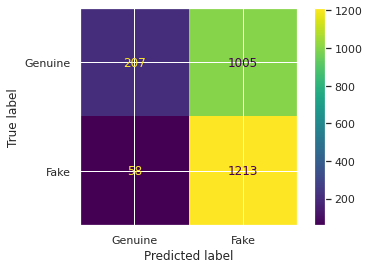

In [ ]:
cmd = ConfusionMatrixDisplay(cm, display_labels=['Genuine','Fake'])
cmd.plot()

In [ ]:
# Verify the results
sk_tn, sk_fp, sk_fn, sk_tp = confusion_matrix(test_y, preds_test).ravel()
print("Verify our results using Sklearn confusion matrix values\n"
      "FN: {0}\n"
      "TP: {1}\n"
      "TN: {2}\n"
      "FP: {3}".format(sk_fn, sk_tp, sk_tn, sk_fp,))

Verify our results using Sklearn confusion matrix values
FN: 35
TP: 1236
TN: 216
FP: 996


In [ ]:
print("Classification Report is is:")
classification_report_results = classification_report(test_y, preds_test)
# store report in results
print(classification_report_results)

Classification Report is is:
              precision    recall  f1-score   support

           0       0.86      0.18      0.30      1212
           1       0.55      0.97      0.71      1271

    accuracy                           0.58      2483
   macro avg       0.71      0.58      0.50      2483
weighted avg       0.70      0.58      0.51      2483



In [ ]:
print("AUC on Test data is " +str(roc_auc_score(test_y,preds_test)))

AUC on Test data is 0.5753402248171315


In [ ]:
# Get baseline results
svc_results = calculate_results(y_true=test_y,
                                     y_pred=preds_test)
svc_results

{'accuracy': 58.477648006443815,
 'precision': 0.553763440860215,
 'recall': 0.9724626278520849,
 'f1': 0.7056808449900085}

In [ ]:
model_results["SVC Tuned"] = 

In [ ]:
model_results

{'BASELINE': {'accuracy': 48.81192106322996,
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0},
 'Linear Regression': {'accuracy': 66.25050342327829,
  'precision': 0.6616878267363704,
  'recall': 0.6970889063729347,
  'f1': 0.6789272030651341},
 'Logistic Regression': {'accuracy': 66.25050342327829,
  'precision': 0.6616878267363704,
  'recall': 0.6970889063729347,
  'f1': 0.6789272030651341},
 'Decision Tree': {'accuracy': 58.840112766814336,
  'precision': 0.5985748218527316,
  'recall': 0.5948072383949646,
  'f1': 0.5966850828729282},
 'Decision Tree Tuned': {'accuracy': 58.477648006443815,
  'precision': 0.553763440860215,
  'recall': 0.9724626278520849,
  'f1': 0.7056808449900085},
 'Random Forest Tuned': {'accuracy': 58.477648006443815,
  'precision': 0.553763440860215,
  'recall': 0.9724626278520849,
  'f1': 0.7056808449900085}}

### Support Vector Machines: Other Variants

In [95]:
from sklearn.svm import LinearSVC, NuSVC, SVC

#### 1. Linear SVC

In [96]:
from sklearn.svm import LinearSVC

svc = LinearSVC(random_state = 1)
_ = svc.fit(X_train, y_train)

In [97]:
#predictions on test data
preds_test= svc.predict(X_test)

In [98]:
#f1 score on test set
f1_value = f1_score(y_test, preds_test)
print(f1_value)

0.662090007627765


In [99]:
# Tuning on C hyperparameter
for c in range(1, 21, 1):
    c = c / 10
    svc = LinearSVC(random_state = 1, C=c)
    _ = svc.fit(X_train, y_train)
    preds_test= svc.predict(X_test)

    #f1 score on test set
    f1_value = f1_score(y_test, preds_test)
    print(c, f1_value)

0.1 0.6798179059180577
0.2 0.6724791508718726
0.3 0.6714664645699129
0.4 0.668939393939394
0.5 0.6651463321930825
0.6 0.6651428571428571
0.7 0.6626000762485703
0.8 0.663109756097561
0.9 0.6623426173216329
1.0 0.662090007627765
1.1 0.6615795497901564
1.2 0.6600458365164248
1.3 0.6595419847328244
1.4 0.658005349636989
1.5 0.658005349636989
1.6 0.656704980842912
1.7 0.6546431312356102
1.8 0.6536248561565017
1.9 0.6528576908323743
2.0 0.6508240705251055


In [100]:
lin_svc = LinearSVC(random_state=1, C=0.1)
lin_svc = lin_svc.fit(X_train, y_train)

In [101]:
#predictions on test data
preds_test= lin_svc.predict(X_test)

In [102]:
#f1 score on test set
f1_value = f1_score(y_test, preds_test)
print(f1_value)

0.6798179059180577


In [103]:
#accuracy,f1 on test data 
accuracy = accuracy_score(test_y, preds_test)
precision = precision_score(test_y, preds_test)
recall = recall_score(test_y, preds_test)
f1 = f1_score(test_y, preds_test)

print(f'Accuracy score is: {accuracy}')
print(f'Precision score is: {precision}')
print(f'Recall score is: {recall}')
print(f'F1 score is: {f1}')


Accuracy score is: 0.6600886024969794
Precision score is: 0.6564102564102564
Recall score is: 0.7049567269866247
F1 score is: 0.6798179059180577


Confusion Matrix is:
[[743 469]
 [375 896]]


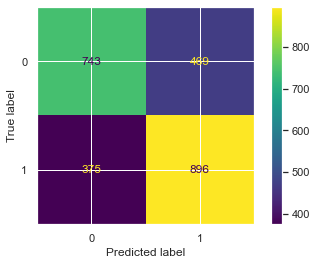

In [104]:
print("Confusion Matrix is:")
print(confusion_matrix(test_y, preds_test))
cm = confusion_matrix(test_y, preds_test)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()


In [105]:
print("Classification Report is is:")
classification_report_results = classification_report(test_y, preds_test)


# store report in results
print(classification_report_results)

Classification Report is is:
              precision    recall  f1-score   support

           0       0.66      0.61      0.64      1212
           1       0.66      0.70      0.68      1271

    accuracy                           0.66      2483
   macro avg       0.66      0.66      0.66      2483
weighted avg       0.66      0.66      0.66      2483



In [106]:
print("AUC on Test data is " +str(roc_auc_score(test_y,preds_test)))

AUC on Test data is 0.6589965153084938


In [107]:
svc_results = calculate_results(y_true=test_y,
                                     y_pred=preds_test)
svc_results

{'accuracy': 66.00886024969795,
 'precision': 0.6564102564102564,
 'recall': 0.7049567269866247,
 'f1': 0.6798179059180577}

In [108]:
model_results["Linear SVC Tuned"] = svc_results

In [110]:
model_results

{'BASELINE': {'accuracy': 48.81192106322996,
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0},
 'XGBoost': {'accuracy': 66.25050342327829,
  'precision': 0.6586080586080586,
  'recall': 0.7073170731707317,
  'f1': 0.6820940819423368},
 'XGBoost Tuned': {'accuracy': 67.41844542891663,
  'precision': 0.6661870503597123,
  'recall': 0.7285601888276947,
  'f1': 0.6959789552799699},
 'Stacking': {'accuracy': 68.5058397100282,
  'precision': 0.6796473181484203,
  'recall': 0.7277734067663257,
  'f1': 0.7028875379939209},
 'Linear SVC Tuned': {'accuracy': 66.00886024969795,
  'precision': 0.6564102564102564,
  'recall': 0.7049567269866247,
  'f1': 0.6798179059180577}}

#### 2. NuSVR

In [63]:
nu_svc = NuSVC()
nu_svc = nu_svc.fit(X_train, y_train)

In [65]:
#predictions on test data
preds_test= nu_svc.predict(X_test)

In [67]:
#f1 score on test set
f1_value = f1_score(y_test, preds_test)
print(f1_value)

0.6830580099884749


In [68]:
#accuracy,f1 on test data 
accuracy = accuracy_score(test_y, preds_test)
precision = precision_score(test_y, preds_test)
recall = recall_score(test_y, preds_test)
f1 = f1_score(test_y, preds_test)

print(f'Accuracy score is: {accuracy}')
print(f'Precision score is: {precision}')
print(f'Recall score is: {recall}')
print(f'F1 score is: {f1}')


Accuracy score is: 0.6677406363270237
Precision score is: 0.6674174174174174
Recall score is: 0.6994492525570417
F1 score is: 0.6830580099884749


Confusion Matrix is:
[[769 443]
 [382 889]]


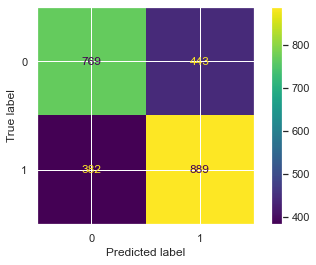

In [69]:
print("Confusion Matrix is:")
print(confusion_matrix(test_y, preds_test))
cm = confusion_matrix(test_y, preds_test)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()


In [70]:
print("Classification Report is is:")
classification_report_results = classification_report(test_y, preds_test)


# store report in results
print(classification_report_results)

Classification Report is is:
              precision    recall  f1-score   support

           0       0.67      0.63      0.65      1212
           1       0.67      0.70      0.68      1271

    accuracy                           0.67      2483
   macro avg       0.67      0.67      0.67      2483
weighted avg       0.67      0.67      0.67      2483



In [71]:
print("AUC on Test data is " +str(roc_auc_score(test_y,preds_test)))

AUC on Test data is 0.6669688507009632


In [72]:
svc_results = calculate_results(y_true=test_y,
                                     y_pred=preds_test)
svc_results

{'accuracy': 66.77406363270238,
 'precision': 0.6674174174174174,
 'recall': 0.6994492525570417,
 'f1': 0.6830580099884749}

In [73]:
model_results["Nu SVC"] = svc_results

In [74]:
model_results

{'BASELINE': {'accuracy': 48.81192106322996,
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0},
 'Linear SVC Tuned': {'accuracy': 66.61296818364882,
  'precision': 0.6596820809248555,
  'recall': 0.7183320220298978,
  'f1': 0.6877589453860641},
 'Nu SVC': {'accuracy': 66.77406363270238,
  'precision': 0.6674174174174174,
  'recall': 0.6994492525570417,
  'f1': 0.6830580099884749}}

In [46]:
# Tuning on the type of kernel for NuSVC
for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
    nu_svc = NuSVC(random_state = 1, kernel=kernel)
    nu_svc = nu_svc.fit(X_train, y_train)
    preds_test= nu_svc.predict(X_test)

    #f1 score on test set
    f1_value = f1_score(y_test, preds_test)
    print(kernel, f1_value)

linear 0.7035573122529645
poly 0.6814214463840399
rbf 0.6830580099884749
sigmoid 0.6035171862509991


In [48]:
nu_svc = NuSVC(random_state = 1, kernel='linear')
nu_svc = nu_svc.fit(X_train, y_train)

In [49]:
#predictions on test data
preds_test= nu_svc.predict(X_test)

In [50]:
#f1 score on test set
f1_value = f1_score(y_test, preds_test)

In [51]:
#accuracy,f1 on test data 
accuracy = accuracy_score(test_y, preds_test)
precision = precision_score(test_y, preds_test)
recall = recall_score(test_y, preds_test)
f1 = f1_score(test_y, preds_test)

print(f'Accuracy score is: {accuracy}')
print(f'Precision score is: {precision}')
print(f'Recall score is: {recall}')
print(f'F1 score is: {f1}')


Accuracy score is: 0.6677406363270237
Precision score is: 0.6474867724867724
Recall score is: 0.7702596380802518
F1 score is: 0.7035573122529645


Confusion Matrix is:
[[679 533]
 [292 979]]


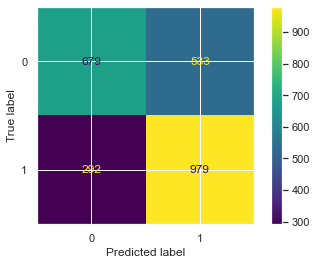

In [52]:
print("Confusion Matrix is:")
print(confusion_matrix(test_y, preds_test))
cm = confusion_matrix(test_y, preds_test)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()


In [53]:
print("Classification Report is is:")
classification_report_results = classification_report(test_y, preds_test)


# store report in results
print(classification_report_results)

Classification Report is is:
              precision    recall  f1-score   support

           0       0.70      0.56      0.62      1212
           1       0.65      0.77      0.70      1271

    accuracy                           0.67      2483
   macro avg       0.67      0.67      0.66      2483
weighted avg       0.67      0.67      0.66      2483



In [54]:
print("AUC on Test data is " +str(roc_auc_score(test_y,preds_test)))

AUC on Test data is 0.665245330591281


In [55]:
svc_results = calculate_results(y_true=test_y,
                                     y_pred=preds_test)
svc_results

{'accuracy': 66.77406363270238,
 'precision': 0.6474867724867724,
 'recall': 0.7702596380802518,
 'f1': 0.7035573122529645}

In [56]:
model_results["Nu SVC Tuned"] = svc_results

In [57]:
model_results

{'Nu SVC Tuned': {'accuracy': 66.77406363270238,
  'precision': 0.6474867724867724,
  'recall': 0.7702596380802518,
  'f1': 0.7035573122529645}}

#### 3. RBF-Kernel SVR

In [58]:
rbf_svc = SVC(kernel='rbf')
rbf_svc.fit(X_train, y_train)

SVC()

In [59]:
#predictions on test data
preds_test= rbf_svc.predict(X_test)

In [60]:
#f1 score on test set
f1_value = f1_score(y_test, preds_test)
print(f1_value)

0.6804979253112035


In [61]:
#accuracy,f1 on test data 
accuracy = accuracy_score(test_y, preds_test)
precision = precision_score(test_y, preds_test)
recall = recall_score(test_y, preds_test)
f1 = f1_score(test_y, preds_test)

print(f'Accuracy score is: {accuracy}')
print(f'Precision score is: {precision}')
print(f'Recall score is: {recall}')
print(f'F1 score is: {f1}')


Accuracy score is: 0.6588803866290778
Precision score is: 0.6536231884057971
Recall score is: 0.7096774193548387
F1 score is: 0.6804979253112035


Confusion Matrix is:
[[734 478]
 [369 902]]


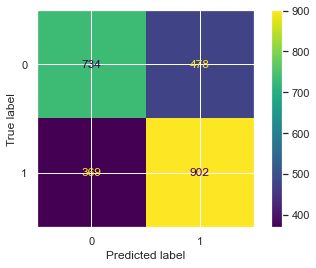

In [62]:
print("Confusion Matrix is:")
print(confusion_matrix(test_y, preds_test))
cm = confusion_matrix(test_y, preds_test)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()


In [63]:
print("Classification Report is is:")
classification_report_results = classification_report(test_y, preds_test)


# store report in results
print(classification_report_results)

Classification Report is is:
              precision    recall  f1-score   support

           0       0.67      0.61      0.63      1212
           1       0.65      0.71      0.68      1271

    accuracy                           0.66      2483
   macro avg       0.66      0.66      0.66      2483
weighted avg       0.66      0.66      0.66      2483



In [64]:
print("AUC on Test data is " +str(roc_auc_score(test_y,preds_test)))

AUC on Test data is 0.6576439902054722


In [65]:
svc_results = calculate_results(y_true=test_y,
                                     y_pred=preds_test)
svc_results

{'accuracy': 65.88803866290777,
 'precision': 0.6536231884057971,
 'recall': 0.7096774193548387,
 'f1': 0.6804979253112035}

In [66]:
model_results["RBF Kernel SVC"] = svc_results

In [67]:
model_results

{'Nu SVC Tuned': {'accuracy': 66.77406363270238,
  'precision': 0.6474867724867724,
  'recall': 0.7702596380802518,
  'f1': 0.7035573122529645},
 'RBF Kernel SVC': {'accuracy': 65.88803866290777,
  'precision': 0.6536231884057971,
  'recall': 0.7096774193548387,
  'f1': 0.6804979253112035}}

**Now we will tune the 'C' parameter for RBF Kernel SVC.**

In [69]:
svc_rbf_c_results = {}

In [71]:
for c in range(2, 41, 2):
    c = c / 10
    rbf_svc = SVC(kernel="rbf",C=c)
    rbf_svc = rbf_svc.fit(X_train, y_train)

    #predictions on test data
    preds_test= rbf_svc.predict(X_test)

    #f1 score on test set
    f1_value = f1_score(y_test, preds_test)
    #print(f1_value)
    
    svc_rbf_c_results[c] = f1_value
    print(c, f1_value)

0.6608231707317074
0.2 0.6608231707317074
0.6742857142857142
0.4 0.6742857142857142
0.6783004552352048
0.6 0.6783004552352048
0.6797583081570997
0.8 0.6797583081570997
0.6804979253112035
1.0 0.6804979253112035
0.6837349397590361
1.2 0.6837349397590361
0.6870056497175141
1.4 0.6870056497175141
0.6857789513391173
1.6 0.6857789513391173
0.6840513983371127
1.8 0.6840513983371127
0.6861480075901328
2.0 0.6861480075901328
0.6854317230886269
2.2 0.6854317230886269
0.6846709775580069
2.4 0.6846709775580069
0.6844512195121952
2.6 0.6844512195121952
0.6822179732313575
2.8 0.6822179732313575
0.6822896657702651
3.0 0.6822896657702651
0.681800692574067
3.2 0.681800692574067
0.68081821690467
3.4 0.68081821690467
0.6811145510835914
3.6 0.6811145510835914
0.6795815575358388
3.8 0.6795815575358388
0.6783081102056655
4.0 0.6783081102056655


In [74]:
sorted(svc_rbf_c_results.items(), key=lambda x: x[1])[-1]

(1.4, 0.6870056497175141)

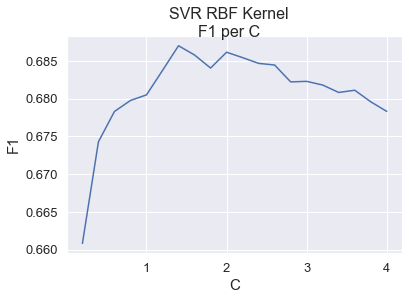

In [75]:
svc_rbf_c_results_df = (
    pd.DataFrame(svc_rbf_c_results.items(), columns=["C", "F1"])
    .sort_values("C")
    .reset_index(drop=True)
)
ax = sns.lineplot(x="C", y="F1", data=svc_rbf_c_results_df, color="b")
plt.suptitle("SVR RBF Kernel\nF1 per C", fontsize=16)
ax.set_xlabel("C", fontsize=15)
ax.set_ylabel("F1", fontsize=15)
ax.xaxis.set_tick_params(labelsize=13)
ax.yaxis.set_tick_params(labelsize=13)

#### SVM Model with best hyperparameters:

In [76]:
rbf_svc = SVC(kernel="rbf",C=1.4)
rbf_svc = rbf_svc.fit(X_train, y_train)

#predictions on test data
preds_test= rbf_svc.predict(X_test)

In [77]:
#predictions on test data
preds_test= rbf_svc.predict(X_test)

In [78]:
#f1 score on test set
f1_value = f1_score(y_test, preds_test)
print(f1_value)

0.6870056497175141


In [79]:
#accuracy,f1 on test data 
accuracy = accuracy_score(test_y, preds_test)
precision = precision_score(test_y, preds_test)
recall = recall_score(test_y, preds_test)
f1 = f1_score(test_y, preds_test)

print(f'Accuracy score is: {accuracy}')
print(f'Precision score is: {precision}')
print(f'Recall score is: {recall}')
print(f'F1 score is: {f1}')


Accuracy score is: 0.6653242045912203
Precision score is: 0.6589595375722543
Recall score is: 0.7175452399685287
F1 score is: 0.6870056497175141


Confusion Matrix is:
[[740 472]
 [359 912]]


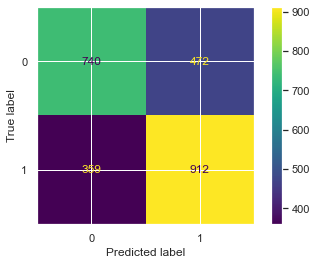

In [80]:
print("Confusion Matrix is:")
print(confusion_matrix(test_y, preds_test))
cm = confusion_matrix(test_y, preds_test)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()


In [81]:
print("Classification Report is is:")
classification_report_results = classification_report(test_y, preds_test)


# store report in results
print(classification_report_results)

Classification Report is is:
              precision    recall  f1-score   support

           0       0.67      0.61      0.64      1212
           1       0.66      0.72      0.69      1271

    accuracy                           0.67      2483
   macro avg       0.67      0.66      0.66      2483
weighted avg       0.67      0.67      0.66      2483



In [82]:
print("AUC on Test data is " +str(roc_auc_score(test_y,preds_test)))

AUC on Test data is 0.6640531480370695


In [83]:
svc_results = calculate_results(y_true=test_y,
                                     y_pred=preds_test)
svc_results

{'accuracy': 66.53242045912204,
 'precision': 0.6589595375722543,
 'recall': 0.7175452399685287,
 'f1': 0.6870056497175141}

In [84]:
model_results["RBF Kernel SVC Tuned"] = svc_results

In [85]:
model_results

{'Nu SVC Tuned': {'accuracy': 66.77406363270238,
  'precision': 0.6474867724867724,
  'recall': 0.7702596380802518,
  'f1': 0.7035573122529645},
 'RBF Kernel SVC': {'accuracy': 65.88803866290777,
  'precision': 0.6536231884057971,
  'recall': 0.7096774193548387,
  'f1': 0.6804979253112035},
 'RBF Kernel SVC Tuned': {'accuracy': 66.53242045912204,
  'precision': 0.6589595375722543,
  'recall': 0.7175452399685287,
  'f1': 0.6870056497175141}}

### e) XGBoost Model

In [45]:
import xgboost as xgb

In [46]:
# define model
xgb = xgb.XGBClassifier()
xgb = xgb.fit(X_train, y_train)

In [47]:
#predictions on test data
preds_test= xgb.predict(X_test)

In [48]:
#f1 score on test set
f1_value = f1_score(y_test, preds_test)
print(f1_value)

0.6820940819423368


In [49]:
#accuracy,f1 on test data 
accuracy = accuracy_score(test_y, preds_test)
precision = precision_score(test_y, preds_test)
recall = recall_score(test_y, preds_test)
f1 = f1_score(test_y, preds_test)

print(f'Accuracy score is: {accuracy}')
print(f'Precision score is: {precision}')
print(f'Recall score is: {recall}')
print(f'F1 score is: {f1}')


Accuracy score is: 0.662505034232783
Precision score is: 0.6586080586080586
Recall score is: 0.7073170731707317
F1 score is: 0.6820940819423368


Confusion Matrix is:
[[746 466]
 [372 899]]


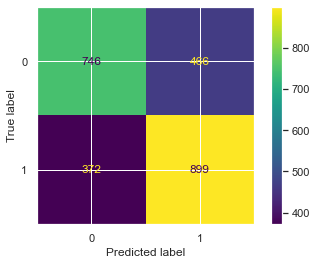

In [50]:
print("Confusion Matrix is:")
print(confusion_matrix(test_y, preds_test))
cm = confusion_matrix(test_y, preds_test)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()


In [51]:
print("Classification Report is is:")
classification_report_results = classification_report(test_y, preds_test)


# store report in results
print(classification_report_results)

Classification Report is is:
              precision    recall  f1-score   support

           0       0.67      0.62      0.64      1212
           1       0.66      0.71      0.68      1271

    accuracy                           0.66      2483
   macro avg       0.66      0.66      0.66      2483
weighted avg       0.66      0.66      0.66      2483



In [52]:
print("AUC on Test data is " +str(roc_auc_score(test_y,preds_test)))

AUC on Test data is 0.6614143121629236


In [54]:
xgb_results = calculate_results(y_true=test_y,
                                     y_pred=preds_test)
xgb_results

{'accuracy': 66.25050342327829,
 'precision': 0.6586080586080586,
 'recall': 0.7073170731707317,
 'f1': 0.6820940819423368}

In [55]:
model_results["XGBoost"] = xgb_results

In [56]:
model_results

{'BASELINE': {'accuracy': 48.81192106322996,
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0},
 'XGBoost': {'accuracy': 66.25050342327829,
  'precision': 0.6586080586080586,
  'recall': 0.7073170731707317,
  'f1': 0.6820940819423368}}

In [59]:
#Hyper-parameter Tuning on XGBoost

import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

params = { 'max_depth': [3, 5, 6, 10, 15, 20],
           'learning_rate': [0.01, 0.1, 0.2, 0.3],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.4, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           'n_estimators': [100, 500, 1000]}

xgbc = xgb.XGBClassifier(seed = 20)

clf = RandomizedSearchCV(estimator=xgbc,
                         param_distributions=params,
                         scoring='f1',
                         n_iter=10,
                         verbose=1)


clf.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None...
                                           n_estimators=100, n_jobs=None,
                                         

In [62]:
print("Best parameters:", clf.best_params_)
print("Highest F1: ", (clf.best_score_))

Best parameters: {'subsample': 0.6, 'n_estimators': 1000, 'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.6}
Highest F1:  0.6857695834499545


In [63]:
# define best model
xgb_tuned = xgb.XGBClassifier(subsample= 0.6, n_estimators= 1000, max_depth= 6, learning_rate= 0.01, colsample_bytree= 0.7, colsample_bylevel= 0.6)
xgb_tuned.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=0.6, colsample_bynode=1, colsample_bytree=0.7,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [65]:
#predictions on test data
preds_test= xgb_tuned.predict(X_test)

In [66]:
#f1 score on test set
f1_value = f1_score(y_test, preds_test)
print(f1_value)

0.6959789552799699


In [67]:
#accuracy,f1 on test data 
accuracy = accuracy_score(test_y, preds_test)
precision = precision_score(test_y, preds_test)
recall = recall_score(test_y, preds_test)
f1 = f1_score(test_y, preds_test)

print(f'Accuracy score is: {accuracy}')
print(f'Precision score is: {precision}')
print(f'Recall score is: {recall}')
print(f'F1 score is: {f1}')


Accuracy score is: 0.6741844542891663
Precision score is: 0.6661870503597123
Recall score is: 0.7285601888276947
F1 score is: 0.6959789552799699


Confusion Matrix is:
[[748 464]
 [345 926]]


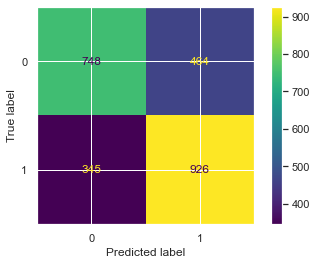

In [68]:
print("Confusion Matrix is:")
print(confusion_matrix(test_y, preds_test))
cm = confusion_matrix(test_y, preds_test)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()


In [69]:
print("Classification Report is is:")
classification_report_results = classification_report(test_y, preds_test)


# store report in results
print(classification_report_results)

Classification Report is is:
              precision    recall  f1-score   support

           0       0.68      0.62      0.65      1212
           1       0.67      0.73      0.70      1271

    accuracy                           0.67      2483
   macro avg       0.68      0.67      0.67      2483
weighted avg       0.68      0.67      0.67      2483



In [70]:
print("AUC on Test data is " +str(roc_auc_score(test_y,preds_test)))

AUC on Test data is 0.672860952499656


In [71]:
xgb_results = calculate_results(y_true=test_y,
                                     y_pred=preds_test)
xgb_results

{'accuracy': 67.41844542891663,
 'precision': 0.6661870503597123,
 'recall': 0.7285601888276947,
 'f1': 0.6959789552799699}

In [72]:
model_results["XGBoost Tuned"] = xgb_results

In [73]:
model_results

{'BASELINE': {'accuracy': 48.81192106322996,
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0},
 'XGBoost': {'accuracy': 66.25050342327829,
  'precision': 0.6586080586080586,
  'recall': 0.7073170731707317,
  'f1': 0.6820940819423368},
 'XGBoost Tuned': {'accuracy': 67.41844542891663,
  'precision': 0.6661870503597123,
  'recall': 0.7285601888276947,
  'f1': 0.6959789552799699}}

### f) Stacking Classifier Model

In [77]:
from sklearn.ensemble import StackingClassifier

level0 = list()
level0.append(('rbf-svc',SVC(kernel="rbf",C=1.4)))
level0.append(('nu-svc', NuSVC(random_state = 1, kernel='linear')))
level0.append(('xgb', xgb.XGBClassifier(subsample= 0.6, n_estimators= 1000, max_depth= 6, learning_rate= 0.01, colsample_bytree= 0.7, colsample_bylevel= 0.6)))

# define meta learner model
level1 = LogisticRegression()

# define the stacking ensemble
model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)

# fit the model on all available data
model.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('rbf-svc', SVC(C=1.4)),
                               ('nu-svc',
                                NuSVC(kernel='linear', random_state=1)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=0.6,
                                              colsample_bynode=None,
                                              colsample_bytree=0.7,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              gpu_id=None, g...
                                              importance_type=None,


In [80]:
#predictions on test data
preds_test= model.predict(X_test)

#f1 score on test set
f1_value = f1_score(y_test, preds_test)
print(f1_value)

0.7028875379939209


In [81]:
#accuracy,f1 on test data 
accuracy = accuracy_score(test_y, preds_test)
precision = precision_score(test_y, preds_test)
recall = recall_score(test_y, preds_test)
f1 = f1_score(test_y, preds_test)

print(f'Accuracy score is: {accuracy}')
print(f'Precision score is: {precision}')
print(f'Recall score is: {recall}')
print(f'F1 score is: {f1}')

Accuracy score is: 0.6850583971002819
Precision score is: 0.6796473181484203
Recall score is: 0.7277734067663257
F1 score is: 0.7028875379939209


Confusion Matrix is:
[[776 436]
 [346 925]]


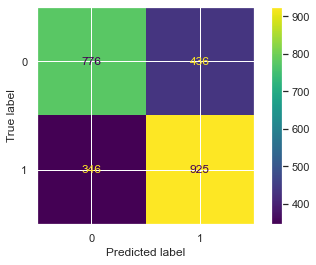

In [82]:
print("Confusion Matrix is:")
print(confusion_matrix(test_y, preds_test))
cm = confusion_matrix(test_y, preds_test)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()

In [83]:
print("Classification Report is is:")
classification_report_results = classification_report(test_y, preds_test)

# store report in results
print(classification_report_results)

Classification Report is is:
              precision    recall  f1-score   support

           0       0.69      0.64      0.66      1212
           1       0.68      0.73      0.70      1271

    accuracy                           0.69      2483
   macro avg       0.69      0.68      0.68      2483
weighted avg       0.69      0.69      0.68      2483



In [84]:
print("AUC on Test data is " +str(roc_auc_score(test_y,preds_test)))



AUC on Test data is 0.684018716584483


In [86]:
stacking_results = calculate_results(y_true=test_y,
                                     y_pred=preds_test)
stacking_results



{'accuracy': 68.5058397100282,
 'precision': 0.6796473181484203,
 'recall': 0.7277734067663257,
 'f1': 0.7028875379939209}

In [87]:
model_results["Stacking"] = stacking_results

model_results

{'BASELINE': {'accuracy': 48.81192106322996,
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0},
 'XGBoost': {'accuracy': 66.25050342327829,
  'precision': 0.6586080586080586,
  'recall': 0.7073170731707317,
  'f1': 0.6820940819423368},
 'XGBoost Tuned': {'accuracy': 67.41844542891663,
  'precision': 0.6661870503597123,
  'recall': 0.7285601888276947,
  'f1': 0.6959789552799699},
 'Stacking': {'accuracy': 68.5058397100282,
  'precision': 0.6796473181484203,
  'recall': 0.7277734067663257,
  'f1': 0.7028875379939209}}

In [92]:
preds_test

array([0, 1, 0, ..., 0, 1, 1])

In [91]:
y_test

7267     1
731      0
9902     0
25894    1
17519    1
        ..
13196    1
10278    1
11476    1
24962    0
17022    0
Name: flagged, Length: 2483, dtype: int64

In [88]:
test_df

,reviewContent,flagged
7267,sunda amazing i heard many good things finally...,1
731,absolutely fantastic foodie community table gr...,0
9902,i work right rarely go here they 5 personal st...,0
25894,this best big 3 brazilian steakhouses chicago ...,1
17519,i lunch the gage group 8 this first time there...,1
...,...,...
13196,there better steak chicago opinion the lobster...,1
10278,it controversial topic i believe giordano s be...,1
11476,this place outrageous i went drinks girls thur...,1
24962,ha i ve eating lunch least twice week two year...,0


In [ ]:
#This is the best performance we could achieve on BoW vectorized features.

In [90]:
# Saving Results to a CSV
def preds_to_csv(df, predictions, file_name="output.csv"):
    final_df = pd.DataFrame(df)
    final_df["pred"] = predictions
    final_df.to_csv(file_name, index=False)
    return f"Final Predictions saved to: {file_name}"

In [93]:
preds_to_csv(test_df, preds_test,"bow-output.csv")

'Final Predictions saved to: bow-output.csv'